In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import copy
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from collections import defaultdict
from torch.utils.data import TensorDataset, DataLoader

In [2]:
bkdatafolder = "/Volumes/T7 Touch/TheseProject/DR_KELLA/BKDataCleaned/"
dataset_name = os.listdir(bkdatafolder)

In [3]:
def createDictFloor(floor_name):
    getdict = {}
    floors = [floor for floor in dataset_name if floor_name in floor]
    for name in floors:
        floorname = name.split(".")[0]
        getdict[floorname] = pd.read_csv(bkdatafolder+name, index_col=0, parse_dates=["Date"])
        getdict[floorname] = getdict[floorname].sort_index()
    return getdict

def Missing_values(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Pourcentage'])
    print (missing_data[(percent>0)],'\n' )

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
def createPlot(date1, date2, features, data):
    for floor in data.keys():
        data[floor].resample("5T").mean()[features][date1:date2].plot(figsize=(20,7))
        

def createDTFeat(date1, date2, datadict, features, resample_method="sum" ,scale=True):
    resample_move = {}
    index_nan = {}
    index_small = {}
    floors = list(datadict.keys())
    dates = []
    scalers = {}
    for data in datadict.keys():
        if resample_method == "sum":
            resample_move[data] = floor_dict[data][date1:date2].resample(
                "5min").sum()
            
        elif resample_method == "max":
            resample_move[data] = floor_dict[data][date1:date2].resample(
                "5min").max().bfill()
        elif resample_method == "mean":
            resample_move[data] = floor_dict[data][date1:date2].resample(
                "5min").mean().bfill()
            
        cols = resample_move[data].columns
        idx = resample_move[data].index

        if scale:
            scaler = MinMaxScaler()
            scaler.fit(resample_move[data])
            resample_move[data] = pd.DataFrame(scaler.transform(
                resample_move[data]),
                                               columns=cols,
                                               index=idx)
            scalers[data] = scaler

        resample_move[data]["weekday"] = resample_move[data].index.day_name()
        resample_move[data]["date"] = resample_move[data].index.date
        resample_move[data]["time"] = resample_move[data].index.time

        nan = np.where(pd.isnull(resample_move[data][features]))[0]
        index_nan[data] = np.unique(resample_move[data].iloc[nan]["time"])

    return resample_move, scalers, index_nan

def getInfoTimeShape(datadict):
    for floor in datadict.keys():
        data = datadict[floor]
        print("Floor : {} , shape :{} , TimeMin {} , TimeMax {}".format(floor,data.shape, data.index.min(), data.index.max()))
        Missing_values(data)
        
def cleanNan(data,idx_nan):
    index=[]
    for k,v in idx_nan.items():
        for ele in v:
            index.append(ele)
    mynan = set(index)
    newdata = data.copy()
    remain_date = []
    for floor in idx_nan.keys():
        datafloor = data[floor]
        todropnan = datafloor[datafloor["date"].isin(list(mynan))].index
        datafloor = datafloor.drop(todropnan)
        newdata[floor] = datafloor
        for date in datafloor["date"]:
            remain_date.append(str(date))
    remain_date = sorted(set(remain_date))
    return data, remain_date

In [4]:
def rolling_window(series, window_size):
    return np.array([series[i : (i + window_size)] for i in range(0, series.shape[0] - window_size + 1)])

def to_timeseries_input(series, lookback, predictions):
    inputs = rolling_window(series[:-predictions], lookback)
    outputs = rolling_window(series[lookback:], predictions)
    return inputs, outputs

def createDataByDate(datadict, features, dates):
    databyDate = defaultdict(lambda : defaultdict(dict))
    for date in dates:
        for floor in datadict.keys():
            databyDate[date][floor] = np.asarray(datadict[floor][date][features])
    return databyDate

def splitDate(dates,cutoff):
    train_date = [x for x in dates if x <= cutoff]
    test_date = sorted(list(set(dates) - set(train_date)))
    return train_date, test_date

def getInfoDataByDate(data, dates):
    for date in dates:
        print("Date : {}".format(date))
        for floor in data[date]:
            print("{} shape : {}".format(floor,data[date][floor].shape))
            
def LoaderByZone(data,zone_name,dates, lookback, lookahead, batch_size, shuffle=False):
    loaderZ = {}
    for i,date in enumerate(dates):
        haruharu = data[date][zone_name]
        trainx, trainy = to_timeseries_input(haruharu, lookback, lookahead,)
        xshape = torch.tensor(trainx, dtype=torch.float).unsqueeze(-1)
        yshape = torch.tensor(trainy, dtype=torch.float)
        tensorwrap = TensorDataset(xshape,yshape)
        loaderxy = DataLoader(tensorwrap,batch_size = batch_size, shuffle=shuffle, drop_last=True)
        loaderZ[date] = loaderxy
    return loaderZ

def LoaderByZoneXY(dataX, dataY, zone_name,dates, seq_len, batch_size, shuffle=False):
    loaderZ = {}
    for i,date in enumerate(dates):
        trainx = rolling_window(dataX[date][zone_name], seq_len)
        trainy = rolling_window(dataY[date][zone_name], seq_len)
        xshape = torch.tensor(trainx, dtype=torch.float).unsqueeze(-1)
        yshape = torch.tensor(trainy, dtype=torch.float)
        tensorwrap = TensorDataset(xshape,yshape)
        loaderxy = DataLoader(tensorwrap,batch_size = batch_size, shuffle=shuffle, drop_last=True)
        loaderZ[date] = loaderxy
    return loaderZ

def LoaderXYtrain(dataX, dataY, zone_name, dates, seq_len, batch_size, shuffle=False, val = True):
    myX = rolling_window(dataX[dates[0]][zone_name], seq_len)
    myY = rolling_window(dataY[dates[0]][zone_name], seq_len)
    for date in dates:
        seqX = rolling_window(dataX[date][zone_name], seq_len)
        seqY = rolling_window(dataY[date][zone_name], seq_len)
        myX = np.vstack((myX, seqX))
        myY = np.vstack((myY, seqY))
    xshape = torch.tensor(myX, dtype=torch.float).unsqueeze(-1)
    yshape = torch.tensor(myY, dtype=torch.float)
    tensorwrap = TensorDataset(xshape, yshape)
    total_data = len(tensorwrap)
    if val:
        train_size = int(0.8*total_data)
        train_set, val_set = torch.utils.data.random_split(tensorwrap, [train_size, total_data - train_size],
                                                          generator=torch.Generator().manual_seed(0))
        loadertrain = DataLoader(train_set, batch_size = batch_size, shuffle=shuffle, drop_last=True)
        loaderval = DataLoader(val_set, batch_size = batch_size, shuffle=shuffle, drop_last=True)
        return loadertrain, loaderval
    else :
        loaderxy = DataLoader(tensorwrap, batch_size= batch_size, shuffle=shuffle, drop_last=True)
        return loaderxy

In [5]:
date1 = "2019-03-07"
date2 = "2019-12-31"
floor_dict = createDictFloor("Floor7")
for data in floor_dict.keys():
    zone = floor_dict[data]
    print("{} Start: {} End: {} Count:{}".format(data,zone.index.min(),zone.index.max(), zone.shape[0]))
    print("")

Floor7Z1 Start: 2019-03-06 14:50:00 End: 2019-12-31 23:59:00 Count:424099

Floor7Z2 Start: 2019-03-06 14:48:00 End: 2019-12-31 23:59:00 Count:424701

Floor7Z4 Start: 2019-03-06 14:46:00 End: 2019-12-31 23:59:00 Count:416243

Floor7Z5 Start: 2019-03-06 14:55:00 End: 2019-12-31 23:59:00 Count:407698



# Model 

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers=1):
        super(Encoder,self).__init__()
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_dim, hid_dim, n_layers, batch_first=False, bias=False)
        
    def forward(self, seq):
        outputs, self.hidden = self.lstm(seq.view(seq.shape[1],seq.shape[0],self.input_dim))
        return outputs, self.hidden
    
    def init_hidden(self, batch_size):
        return (torch.zeros(self.n_layers, batch_size, self.hid_dim),
                torch.zeros(self.n_layers, batch_size, self.hid_dim))
    
class Decoder(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim, n_layers=1):
        super(Decoder,self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hid_dim, n_layers, batch_first = False, bias=False)
        self.fc = nn.Linear(hid_dim, output_dim)
        
    def forward(self, x, encoder_hidden):
        lstm_out, self.hidden = self.lstm(x.unsqueeze(0), encoder_hidden)
        output = self.fc(lstm_out.squeeze(0))
        return output, self.hidden
    
class Seq2Seq(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim, ts_out, forcing = 1):
        super(Seq2Seq,self).__init__()
        self.output_dim = output_dim
        self.ts_out = ts_out
        self.encoder = Encoder(input_dim, hid_dim)
        self.decoder = Decoder(input_dim,hid_dim,output_dim)
        self.forcing = forcing

        
    def forward(self, source, y=None):
        batch_size = source.shape[0]
        target_len = self.ts_out
        outputs = torch.zeros(target_len, batch_size,self.output_dim)
        encoder_hidden = self.encoder.init_hidden(batch_size)
        encoder_output, encoder_hidden = self.encoder(source)
        
        decoder_input = source[:,-1,:]
        decoder_hidden = encoder_hidden
        
        for t in range(target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[t] = decoder_output
            if (y is not None) and (t>1) and (torch.rand(1) < self.forcing):
                decoder_input = y[:,t].unsqueeze(1)
            else :
                decoder_input = decoder_output
        return outputs.squeeze().permute(1,0)
    
    
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, time_step_in, time_step_out):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.time_step_in = time_step_in
        self.time_step_out = time_step_out
        self.num_layers = 1
        
        self.encoder = nn.LSTM(self.input_size, self.output_size,
                               num_layers=self.num_layers, batch_first=True, bias=True)
        
        self.batch = nn.BatchNorm1d(self.output_size)
        self.linear2 = nn.Linear(self.num_layers*self.output_size, self.time_step_out)
        
    def forward(self,x):
        out_en, (h_en,_) = self.encoder(x)
        h_en = h_en.view(-1, self.num_layers*self.output_size)
        h_en = self.batch(h_en)
        out = nn.LeakyReLU()(h_en)
        #out = torch.sigmoid(self.linear(out))
        out = self.linear2(out)
        return out

# Parameters

In [7]:
myfloor = "Floor7Z1"
batch_size = 16
seq_len = 5

# Temp to AC

In [8]:
featureX = "temperature"
featureY = "ACPower"
resampleX_method = "max"
resampleY_method = "sum"
resampleX, scalersX, index_nan = createDTFeat(date1, date2, floor_dict, featureX,resample_method=resampleX_method)
resampleY, scalersY, index_nan = createDTFeat(date1, date2, floor_dict, featureY,resample_method=resampleY_method)
cleanedDataX, remain_date = cleanNan(resampleX, index_nan)
cleanedDataY, remain_date = cleanNan(resampleY, index_nan)

In [9]:
cutting_date = "2019-08-08"
train_date, test_date = splitDate(remain_date, cutting_date)
databyDateX = createDataByDate(cleanedDataX, featureX, remain_date)
databyDateY = createDataByDate(cleanedDataY, featureY, remain_date)
#getInfoDataByDate(databyDateX, train_date)

/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_7908/1374678471.py:13: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  databyDate[date][floor] = np.asarray(datadict[floor][date][features])


In [10]:
loaderZtrain, loaderZval = LoaderXYtrain(databyDateX, databyDateY,myfloor,train_date, seq_len, batch_size, shuffle=True, val=True)
#loaderZtrain = LoaderXYtrain(databyDateX, databyDateY,myfloor,train_date, seq_len, batch_size, shuffle=True, val=False)
loaderZtest = LoaderByZoneXY(databyDateX, databyDateY, myfloor, test_date, seq_len, batch_size, shuffle=False)

In [11]:
def ModelTraining(model, optimizer, loss_fn ,dataloader,valloader,scheduler, epochs=100):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e3
    losses, mape, mae, validlosses, validmae = [], [], [], [], []
    loader = {"Train":dataloader, "Valid":valloader}
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)
        for phase in ["Train","Valid"]:
            if phase=="Train":
                model.train()
            else:
                model.eval()
                
            run_loss, run_mape, run_mae = 0., 0., 0.
            for data, label in loader[phase]:
                optimizer.zero_grad()
                #print("phase {} shape {}".format(phase, data.shape))
                with torch.set_grad_enabled(phase=="Train"):
                    output = model(data)
                    loss_val = loss_fn(output, label)
                    
                    if phase == "Train":
                        loss_val.backward()
                        optimizer.step()
                    
                run_loss += loss_val.item()*data.size(0)
                #run_mape += mean_absolute_percentage_error(label.detach().numpy(),output.detach().numpy())*data.size(0)
                run_mae  += mean_absolute_error(label.detach().numpy(),output.detach().numpy())*data.size(0)
            
            epoch_loss = run_loss/len(loader[phase])
            #epoch_mape = run_mape/len(dataloader)
            epoch_mae = run_mae/len(loader[phase])
            
            #print('{} Loss: {:.4f} MAE: {:.4f}'.format(phase, epoch_loss, epoch_mae))
            
            if phase=="Train":
                losses.append(epoch_loss)
                #mape.append(epoch_mape)
                mae.append(epoch_mae)
                #print("Epoch: {} Loss: {} Best Loss: {} MAPE: {} MAE: {}".format(epoch, epoch_loss, best_loss, epoch_mape, epoch_mae))
                
            elif phase == "Valid":
                validlosses.append(epoch_loss)
                validmae.append(epoch_mae)
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    
            print('[{}]  Loss: {:.4f} MAE: {:.4f} Best : {:.4f}'.format(phase, epoch_loss, epoch_mae, best_loss))
                
            if scheduler is not None:
                scheduler.step()
        
    model.load_state_dict(best_model_wts)
    
    return model, losses, validlosses, mape, mae

In [12]:
loss_fn = nn.SmoothL1Loss()
modelLSTM = LSTM(1, 32, seq_len, seq_len)
optimizerAC = optim.Adam(modelLSTM.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizerAC,step_size=10,gamma=0.1)

In [13]:
trainedAC, losses, validlosses, mape, mae = ModelTraining(modelLSTM, optimizerAC, loss_fn, loaderZtrain,loaderZval,scheduler,epochs=150)

Epoch 0/149
----------
[Train]  Loss: 0.2270 MAE: 1.4992 Best : 1000.0000
[Valid]  Loss: 0.8901 MAE: 4.1328 Best : 0.8901
Epoch 1/149
----------
[Train]  Loss: 0.1858 MAE: 1.2401 Best : 0.8901
[Valid]  Loss: 0.9854 MAE: 5.1235 Best : 0.8901
Epoch 2/149
----------
[Train]  Loss: 0.1639 MAE: 1.1519 Best : 0.8901
[Valid]  Loss: 0.1160 MAE: 1.0020 Best : 0.1160
Epoch 3/149
----------
[Train]  Loss: 0.1483 MAE: 1.1173 Best : 0.1160
[Valid]  Loss: 0.1143 MAE: 1.0461 Best : 0.1143
Epoch 4/149
----------
[Train]  Loss: 0.1404 MAE: 1.1080 Best : 0.1143
[Valid]  Loss: 0.1408 MAE: 1.0117 Best : 0.1143
Epoch 5/149
----------
[Train]  Loss: 0.1116 MAE: 0.8306 Best : 0.1143
[Valid]  Loss: 0.0887 MAE: 0.6892 Best : 0.0887
Epoch 6/149
----------
[Train]  Loss: 0.1061 MAE: 0.8227 Best : 0.0887
[Valid]  Loss: 0.0875 MAE: 0.7204 Best : 0.0875
Epoch 7/149
----------
[Train]  Loss: 0.1018 MAE: 0.8103 Best : 0.0875
[Valid]  Loss: 0.0850 MAE: 0.6300 Best : 0.0850
Epoch 8/149
----------
[Train]  Loss: 0.1025 

[Train]  Loss: 0.0960 MAE: 0.7460 Best : 0.0810
[Valid]  Loss: 0.0840 MAE: 0.6458 Best : 0.0810
Epoch 70/149
----------
[Train]  Loss: 0.0975 MAE: 0.7534 Best : 0.0810
[Valid]  Loss: 0.0820 MAE: 0.5956 Best : 0.0810
Epoch 71/149
----------
[Train]  Loss: 0.0947 MAE: 0.7400 Best : 0.0810
[Valid]  Loss: 0.0818 MAE: 0.5788 Best : 0.0810
Epoch 72/149
----------
[Train]  Loss: 0.0943 MAE: 0.7377 Best : 0.0810
[Valid]  Loss: 0.0822 MAE: 0.6163 Best : 0.0810
Epoch 73/149
----------
[Train]  Loss: 0.0970 MAE: 0.7511 Best : 0.0810
[Valid]  Loss: 0.0819 MAE: 0.5739 Best : 0.0810
Epoch 74/149
----------
[Train]  Loss: 0.0952 MAE: 0.7408 Best : 0.0810
[Valid]  Loss: 0.0836 MAE: 0.5987 Best : 0.0810
Epoch 75/149
----------
[Train]  Loss: 0.0939 MAE: 0.7407 Best : 0.0810
[Valid]  Loss: 0.0817 MAE: 0.6184 Best : 0.0810
Epoch 76/149
----------
[Train]  Loss: 0.0952 MAE: 0.7373 Best : 0.0810
[Valid]  Loss: 0.0813 MAE: 0.5727 Best : 0.0810
Epoch 77/149
----------
[Train]  Loss: 0.0965 MAE: 0.7485 Best :

[Train]  Loss: 0.0966 MAE: 0.7460 Best : 0.0810
[Valid]  Loss: 0.0821 MAE: 0.5713 Best : 0.0810
Epoch 138/149
----------
[Train]  Loss: 0.0948 MAE: 0.7413 Best : 0.0810
[Valid]  Loss: 0.0828 MAE: 0.6018 Best : 0.0810
Epoch 139/149
----------
[Train]  Loss: 0.0938 MAE: 0.7371 Best : 0.0810
[Valid]  Loss: 0.0824 MAE: 0.6044 Best : 0.0810
Epoch 140/149
----------
[Train]  Loss: 0.0956 MAE: 0.7447 Best : 0.0810
[Valid]  Loss: 0.0825 MAE: 0.5849 Best : 0.0810
Epoch 141/149
----------
[Train]  Loss: 0.0952 MAE: 0.7412 Best : 0.0810
[Valid]  Loss: 0.0827 MAE: 0.5924 Best : 0.0810
Epoch 142/149
----------
[Train]  Loss: 0.0971 MAE: 0.7490 Best : 0.0810
[Valid]  Loss: 0.0826 MAE: 0.6024 Best : 0.0810
Epoch 143/149
----------
[Train]  Loss: 0.0962 MAE: 0.7429 Best : 0.0810
[Valid]  Loss: 0.0826 MAE: 0.5982 Best : 0.0810
Epoch 144/149
----------
[Train]  Loss: 0.0940 MAE: 0.7413 Best : 0.0810
[Valid]  Loss: 0.0819 MAE: 0.5824 Best : 0.0810
Epoch 145/149
----------
[Train]  Loss: 0.0955 MAE: 0.746

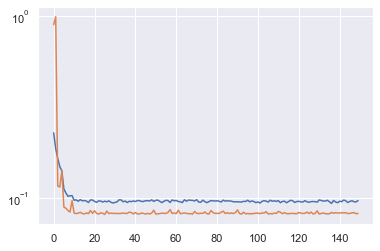

In [14]:
plt.plot(losses)
plt.plot(validlosses)
plt.yscale("log")

In [15]:
def ModelPrediction(model_to_test, date ,loader, lookahead):
    prediction = []
    true = []
    for val, valpred in loader[date]:
        model_to_test.eval()
        pred = model_to_test(val)
        #print(pred.shape)
        prediction.append(pred.detach().numpy())
        true.append(valpred.detach().numpy())
    pred_array = np.asarray(prediction)
    true_array = np.asarray(true)
    pred_shape = pred_array.shape
    flattenTrue = true_array.reshape(pred_shape[0]*pred_shape[1], lookahead)[::lookahead].flatten()
    flattenPred = pred_array.reshape(pred_shape[0]*pred_shape[1], lookahead)[::lookahead].flatten()
    return flattenTrue, flattenPred

def PredictionMultipleDate(model, dates, date_begin, date_end, loader, lookahead, scalers, zone_name, ft_idx):
    predictTrue = []
    predictPred = []
    valuePD = pd.DataFrame()
    idx_begin = dates.index(date_begin)
    idx_end = dates.index(date_end)
    for date in dates[idx_begin:idx_end]:
        true, pred = ModelPrediction(model, date, loader, lookahead)
        maxi = scalers[zone_name].data_max_[ft_idx]
        mini = scalers[zone_name].data_min_[ft_idx]
        true = true.reshape(-1,1)*(maxi-mini) + mini
        pred = pred.reshape(-1,1)*(maxi-mini) + mini
        array = np.concatenate([true, pred],axis=1)
        result = pd.DataFrame({"Truth": true.squeeze(),
                              "Prediction" : pred.squeeze()})
                              #"Date": pd.date_range(start=date,periods=true.shape[0], freq="5min")})
        valuePD = pd.concat((valuePD, result)).reset_index(drop=True)
    return valuePD

In [114]:
ft_idx = 0
may = [date for date in test_date if '2019-08' in date]
resultpd = PredictionMultipleDate(trainedAC,test_date,may[5], may[10],loaderZtest, seq_len, scalersY, myfloor, ft_idx)

<AxesSubplot:>

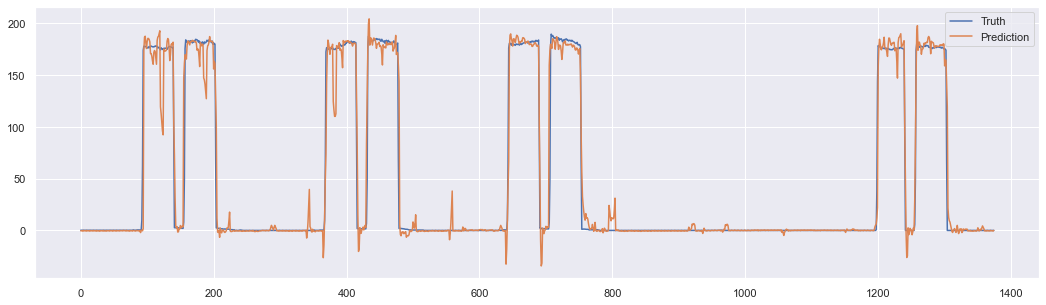

In [115]:
resultpd[["Truth","Prediction"]].plot(figsize=(18,5))#,title="Model_"+str(indexroom))

In [18]:
true, pred = ModelPrediction(trainedAC,"2019-08-23", loaderZtest, seq_len)

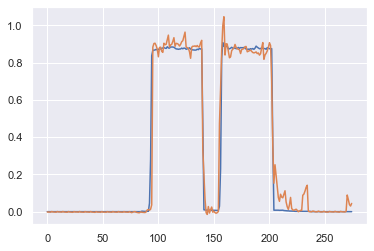

In [19]:
plt.plot(true)
plt.plot(pred)

In [25]:
torch.save(trainedAC.state_dict(), "./TempToACModel.pt")

# Lux To IlPower

In [20]:
featureLux = "lux"
featureIll = "lightPower"
resampleX_method = "max"
resampleY_method = "sum"
cutting_date = "2019-08-08"
#train_date, test_date = splitDate(remain_date, cutting_date)
databyDateLux = createDataByDate(cleanedDataX, featureLux, remain_date)
databyDateIll = createDataByDate(cleanedDataY, featureIll, remain_date)
#getInfoDataByDate(databyDateX, train_date)

/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_7908/1374678471.py:13: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  databyDate[date][floor] = np.asarray(datadict[floor][date][features])


In [21]:
loaderLuxtrain, loaderLuxval = LoaderXYtrain(databyDateLux, databyDateIll,myfloor,train_date, seq_len, batch_size, shuffle=True, val=True)
#loaderZtrain = LoaderXYtrain(databyDateX, databyDateY,myfloor,train_date, seq_len, batch_size, shuffle=True, val=False)
loaderLuxtest = LoaderByZoneXY(databyDateLux, databyDateIll, myfloor, test_date, seq_len, batch_size, shuffle=False)

In [22]:
loss_fn = nn.SmoothL1Loss()
modelLux = LSTM(1, 32, seq_len, seq_len)
optimizerLux = optim.Adam(modelLux.parameters(), lr=0.01)
schedulerLux = optim.lr_scheduler.StepLR(optimizerLux,step_size=10,gamma=0.1)

In [23]:
trainedLux, Luxlosses, Luxvalidlosses, Luxmape, Luxmae = ModelTraining(modelLux, optimizerLux, loss_fn, 
                                                                       loaderLuxtrain,loaderLuxval,schedulerLux,epochs=150)

Epoch 0/149
----------
[Train]  Loss: 0.2433 MAE: 2.0188 Best : 1000.0000
[Valid]  Loss: 0.1933 MAE: 1.7033 Best : 0.1933
Epoch 1/149
----------
[Train]  Loss: 0.2144 MAE: 1.8257 Best : 0.1933
[Valid]  Loss: 0.2568 MAE: 2.3554 Best : 0.1933
Epoch 2/149
----------
[Train]  Loss: 0.2116 MAE: 1.7978 Best : 0.1933
[Valid]  Loss: 0.3065 MAE: 2.6425 Best : 0.1933
Epoch 3/149
----------
[Train]  Loss: 0.2114 MAE: 1.7878 Best : 0.1933
[Valid]  Loss: 0.2144 MAE: 2.1488 Best : 0.1933
Epoch 4/149
----------
[Train]  Loss: 0.2092 MAE: 1.7801 Best : 0.1933
[Valid]  Loss: 0.2116 MAE: 1.8304 Best : 0.1933
Epoch 5/149
----------
[Train]  Loss: 0.2035 MAE: 1.7086 Best : 0.1933
[Valid]  Loss: 0.1875 MAE: 1.5375 Best : 0.1875
Epoch 6/149
----------
[Train]  Loss: 0.2020 MAE: 1.7047 Best : 0.1875
[Valid]  Loss: 0.1897 MAE: 1.5296 Best : 0.1875
Epoch 7/149
----------
[Train]  Loss: 0.2001 MAE: 1.6986 Best : 0.1875
[Valid]  Loss: 0.1895 MAE: 1.7524 Best : 0.1875
Epoch 8/149
----------
[Train]  Loss: 0.1973 

[Train]  Loss: 0.1896 MAE: 1.6325 Best : 0.1804
[Valid]  Loss: 0.1805 MAE: 1.5396 Best : 0.1804
Epoch 70/149
----------
[Train]  Loss: 0.1908 MAE: 1.6352 Best : 0.1804
[Valid]  Loss: 0.1808 MAE: 1.5164 Best : 0.1804
Epoch 71/149
----------
[Train]  Loss: 0.1913 MAE: 1.6399 Best : 0.1804
[Valid]  Loss: 0.1816 MAE: 1.4927 Best : 0.1804
Epoch 72/149
----------
[Train]  Loss: 0.1903 MAE: 1.6339 Best : 0.1804
[Valid]  Loss: 0.1808 MAE: 1.5173 Best : 0.1804
Epoch 73/149
----------
[Train]  Loss: 0.1906 MAE: 1.6351 Best : 0.1804
[Valid]  Loss: 0.1810 MAE: 1.5415 Best : 0.1804
Epoch 74/149
----------
[Train]  Loss: 0.1904 MAE: 1.6335 Best : 0.1804
[Valid]  Loss: 0.1826 MAE: 1.5255 Best : 0.1804
Epoch 75/149
----------
[Train]  Loss: 0.1903 MAE: 1.6329 Best : 0.1804
[Valid]  Loss: 0.1808 MAE: 1.5168 Best : 0.1804
Epoch 76/149
----------
[Train]  Loss: 0.1913 MAE: 1.6370 Best : 0.1804
[Valid]  Loss: 0.1806 MAE: 1.5142 Best : 0.1804
Epoch 77/149
----------
[Train]  Loss: 0.1905 MAE: 1.6396 Best :

[Train]  Loss: 0.1913 MAE: 1.6390 Best : 0.1803
[Valid]  Loss: 0.1812 MAE: 1.4992 Best : 0.1803
Epoch 138/149
----------
[Train]  Loss: 0.1911 MAE: 1.6370 Best : 0.1803
[Valid]  Loss: 0.1802 MAE: 1.5518 Best : 0.1802
Epoch 139/149
----------
[Train]  Loss: 0.1901 MAE: 1.6329 Best : 0.1802
[Valid]  Loss: 0.1813 MAE: 1.4937 Best : 0.1802
Epoch 140/149
----------
[Train]  Loss: 0.1895 MAE: 1.6299 Best : 0.1802
[Valid]  Loss: 0.1804 MAE: 1.5030 Best : 0.1802
Epoch 141/149
----------
[Train]  Loss: 0.1906 MAE: 1.6387 Best : 0.1802
[Valid]  Loss: 0.1811 MAE: 1.4928 Best : 0.1802
Epoch 142/149
----------
[Train]  Loss: 0.1911 MAE: 1.6378 Best : 0.1802
[Valid]  Loss: 0.1820 MAE: 1.4866 Best : 0.1802
Epoch 143/149
----------
[Train]  Loss: 0.1908 MAE: 1.6386 Best : 0.1802
[Valid]  Loss: 0.1808 MAE: 1.5225 Best : 0.1802
Epoch 144/149
----------
[Train]  Loss: 0.1903 MAE: 1.6342 Best : 0.1802
[Valid]  Loss: 0.1810 MAE: 1.4924 Best : 0.1802
Epoch 145/149
----------
[Train]  Loss: 0.1918 MAE: 1.641

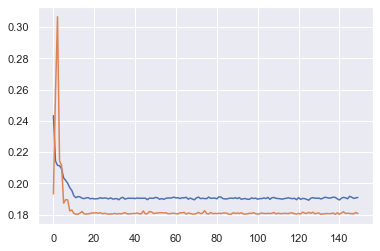

In [24]:
plt.plot(Luxlosses)
plt.plot(Luxvalidlosses)
#plt.yscale("log")

In [56]:
floor_dict["Floor7Z1"]["lightPower"]

Date
2019-03-06 14:50:00    2.32
2019-03-06 15:39:00    2.30
2019-03-06 15:40:00    2.31
2019-03-06 15:41:00    2.31
2019-03-06 15:42:00    2.31
                       ... 
2019-12-31 23:55:00    0.00
2019-12-31 23:56:00    0.00
2019-12-31 23:57:00    0.00
2019-12-31 23:58:00    0.00
2019-12-31 23:59:00    0.00
Name: lightPower, Length: 424099, dtype: float64

In [111]:
ft_idx = 1
may = [date for date in test_date if '2019-08' in date]
resultpdLux = PredictionMultipleDate(trainedLux,test_date,may[5], may[10],loaderLuxtest, seq_len, scalersY, myfloor, ft_idx)

<AxesSubplot:>

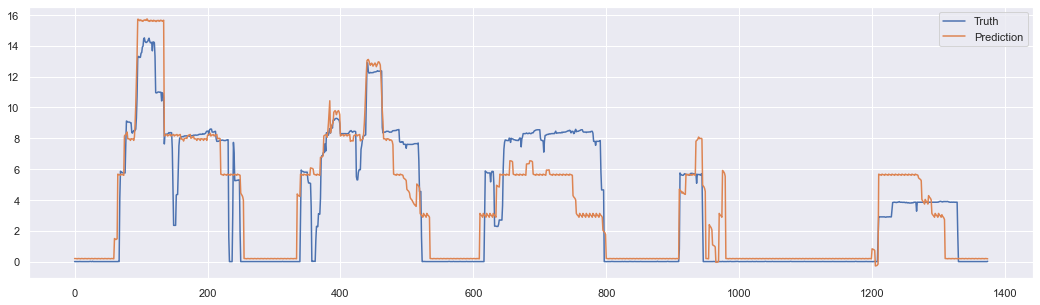

In [112]:
resultpdLux[["Truth","Prediction"]].plot(figsize=(18,5))#,title="Model_"+str(indexroom))

In [28]:
torch.save(trainedLux.state_dict(), "./LuxToIllModel.pt")

# Concatenation Data 

In [67]:
def concatTensor(x1, x2):
    return torch.cat([x1, x2],dim=-1)

def LoaderConcatData(loader1, loader2, model1, model2, batch_size=16, shuffle=True):
    dataX, dataY1, dataY2 = [], [], []
    for i,(data1, data2) in enumerate(zip(loader1, loader2)):
        x1,y1 = data1
        x2,y2 = data2
        intend1 = model1.encoder(x1)[1][0].detach()
        intend2 = model2.encoder(x2)[1][0].detach()
        shape1, shape2 = intend1.shape, intend2.shape
        intend1 = intend1.view(shape1[0]*shape1[1], -1)
        intend2 = intend2.view(shape2[0]*shape2[1], -1)
        concat = concatTensor(intend1, intend2)
        dataX.append(concat)
        dataY1.append(y1)
        dataY2.append(y2)
    
    myX, myY1, myY2= torch.stack(dataX), torch.stack(dataY1), torch.stack(dataY2)
    myX = myX.view(myX.size(0)*myX.size(1), -1)
    myY1 = myY1.view(myY1.size(0)*myY1.size(1),-1)
    myY2 = myY2.view(myY2.size(0)*myY2.size(1),-1)
    
    dataset1 = TensorDataset(myX, myY1)
    dataset2 = TensorDataset(myX, myY2)
    
    loaderfinal1 = DataLoader(dataset1, batch_size=batch_size, drop_last=True, shuffle=shuffle)
    loaderfinal2 = DataLoader(dataset2, batch_size=batch_size, drop_last=True, shuffle=shuffle)
    
    return loaderfinal1, loaderfinal2

def LoaderConcatbyDate(loader1, loader2, model1, model2, batch_size=16, shuffle=False):
    dates = list(loader1.keys())
    loaderY1 = {}
    loaderY2 = {}
    for date in dates:
        dataX, dataY1, dataY2 = [], [], []
        for i,(data1,data2) in enumerate(zip(loader1[date], loader2[date])):
            x1,y1 = data1
            x2,y2 = data2
            intend1 = model1.encoder(x1)[1][0].detach()
            intend2 = model2.encoder(x2)[1][0].detach()
            shape1, shape2 = intend1.shape, intend2.shape
            intend1 = intend1.view(shape1[0]*shape1[1], -1)
            intend2 = intend2.view(shape2[0]*shape2[1], -1)
            concat = concatTensor(intend1, intend2)
            dataX.append(concat)
            dataY1.append(y1)
            dataY2.append(y2)
    
        myX, myY1, myY2= torch.stack(dataX), torch.stack(dataY1), torch.stack(dataY2)
        myX = myX.view(myX.size(0)*myX.size(1), -1)
        myY1 = myY1.view(myY1.size(0)*myY1.size(1),-1)
        myY2 = myY2.view(myY2.size(0)*myY2.size(1),-1)

        dataset1 = TensorDataset(myX, myY1)
        dataset2 = TensorDataset(myX, myY2)

        loaderfinal1 = DataLoader(dataset1, batch_size=batch_size, drop_last=True, shuffle=shuffle)
        loaderfinal2 = DataLoader(dataset2, batch_size=batch_size, drop_last=True, shuffle=shuffle)
        
        loaderY1[date] = loaderfinal1
        loaderY2[date] = loaderfinal2
    return loaderY1, loaderY2


def LoaderConcat(dataX, dataY):
    myX = dataX.view(dataX.size(0)*dataX.size(1), -1)
    myY = dataY.view(dataY.size(0)*dataY.size(1), -1)
    mydataset = TensorDataset(myX, myY)
    loader = DataLoader(mydataset, batch_size=16, drop_last=True, shuffle=True)
    return loader

In [64]:
loaderEACtrain, loaderEIlltrain = LoaderConcatData(loaderZtrain, loaderLuxtrain, trainedAC, trainedLux)
loaderEACval, loaderEIllval = LoaderConcatData(loaderZval, loaderLuxval, trainedAC, trainedLux)

In [68]:
loaderEACtest, loaderEIlltest = LoaderConcatbyDate(loaderZtest, loaderLuxtest, trainedAC, trainedLux)

In [80]:
class Linear(nn.Module):
    def __init__(self, nb_units, input_dim, output_dim):
        super(Linear, self).__init__()
        
        self.nb_units = nb_units
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.nb_units2 = 16
    
        self.fc1 = nn.Linear(input_dim, nb_units)
        self.fc3 = nn.Linear(nb_units, output_dim)
        
        self.batch1 = nn.BatchNorm1d(nb_units)
        self.drop = nn.Dropout(0.5)
        
    def forward(self, x):
        inputs = x.squeeze(-1)
        out = self.fc1(inputs)
        out = self.batch1(out)
        out = nn.ReLU()(out)
        
        out = self.fc3(out)
        return out

In [100]:
PowerPredictorAC = Linear(16,64, 5)
optPPLAC = optim.Adam(PowerPredictorAC.parameters(), lr=0.01)
schePPLAC = optim.lr_scheduler.StepLR(optPPLAC,step_size=10,gamma=0.1)

In [101]:
modelPPLAC, pplAClosses, pplACvalidlosses, pplACmape, pplACmae = ModelTraining(PowerPredictorAC, optPPLAC, loss_fn, 
                                                                       loaderEACtrain,loaderEACval,schePPLAC,epochs=100)

Epoch 0/99
----------
[Train]  Loss: 0.2311 MAE: 1.7016 Best : 1000.0000
[Valid]  Loss: 0.1548 MAE: 1.5250 Best : 0.1548
Epoch 1/99
----------
[Train]  Loss: 0.1484 MAE: 1.1857 Best : 0.1548
[Valid]  Loss: 0.1005 MAE: 0.9073 Best : 0.1005
Epoch 2/99
----------
[Train]  Loss: 0.1438 MAE: 1.1704 Best : 0.1005
[Valid]  Loss: 0.0975 MAE: 0.8305 Best : 0.0975
Epoch 3/99
----------
[Train]  Loss: 0.1440 MAE: 1.1598 Best : 0.0975
[Valid]  Loss: 0.1030 MAE: 0.8454 Best : 0.0975
Epoch 4/99
----------
[Train]  Loss: 0.1404 MAE: 1.1274 Best : 0.0975
[Valid]  Loss: 0.1076 MAE: 0.9927 Best : 0.0975
Epoch 5/99
----------
[Train]  Loss: 0.1260 MAE: 0.9608 Best : 0.0975
[Valid]  Loss: 0.0926 MAE: 0.7520 Best : 0.0926
Epoch 6/99
----------
[Train]  Loss: 0.1259 MAE: 0.9471 Best : 0.0926
[Valid]  Loss: 0.0918 MAE: 0.6630 Best : 0.0918
Epoch 7/99
----------
[Train]  Loss: 0.1229 MAE: 0.9284 Best : 0.0918
[Valid]  Loss: 0.0901 MAE: 0.7073 Best : 0.0901
Epoch 8/99
----------
[Train]  Loss: 0.1237 MAE: 0.93

[Train]  Loss: 0.1222 MAE: 0.8894 Best : 0.0880
[Valid]  Loss: 0.0888 MAE: 0.6859 Best : 0.0880
Epoch 70/99
----------
[Train]  Loss: 0.1187 MAE: 0.8828 Best : 0.0880
[Valid]  Loss: 0.0899 MAE: 0.6790 Best : 0.0880
Epoch 71/99
----------
[Train]  Loss: 0.1219 MAE: 0.8954 Best : 0.0880
[Valid]  Loss: 0.0888 MAE: 0.6608 Best : 0.0880
Epoch 72/99
----------
[Train]  Loss: 0.1199 MAE: 0.8840 Best : 0.0880
[Valid]  Loss: 0.0889 MAE: 0.6608 Best : 0.0880
Epoch 73/99
----------
[Train]  Loss: 0.1227 MAE: 0.8918 Best : 0.0880
[Valid]  Loss: 0.0884 MAE: 0.6734 Best : 0.0880
Epoch 74/99
----------
[Train]  Loss: 0.1206 MAE: 0.8914 Best : 0.0880
[Valid]  Loss: 0.0916 MAE: 0.6636 Best : 0.0880
Epoch 75/99
----------
[Train]  Loss: 0.1213 MAE: 0.8945 Best : 0.0880
[Valid]  Loss: 0.0890 MAE: 0.6800 Best : 0.0880
Epoch 76/99
----------
[Train]  Loss: 0.1191 MAE: 0.8842 Best : 0.0880
[Valid]  Loss: 0.0895 MAE: 0.6729 Best : 0.0880
Epoch 77/99
----------
[Train]  Loss: 0.1237 MAE: 0.8977 Best : 0.0880


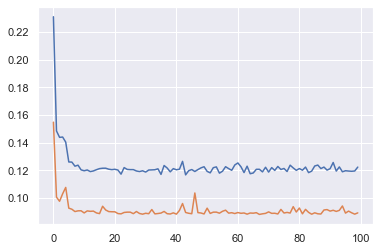

In [102]:
plt.plot(pplAClosses)
plt.plot(pplACvalidlosses)

In [103]:
ft_idx = 0
may = [date for date in test_date if '2019-08' in date]
resultpdEAC = PredictionMultipleDate(modelPPLAC,test_date,may[5], may[10],loaderEACtest, seq_len, scalersY, myfloor, ft_idx)

<AxesSubplot:>

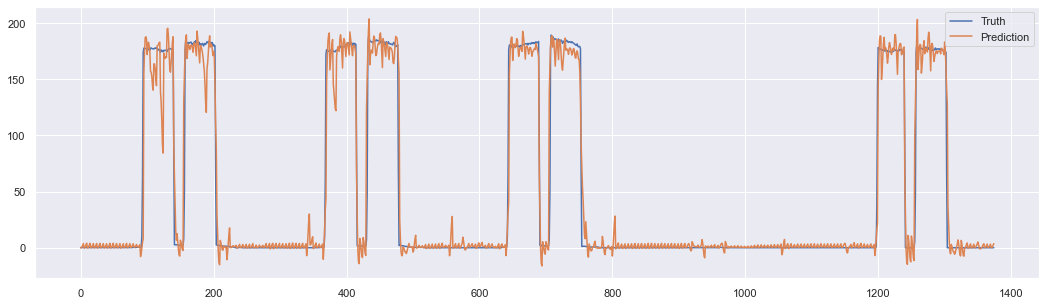

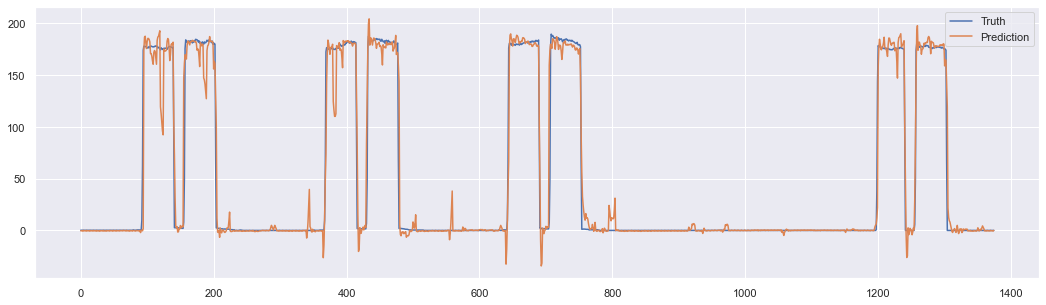

In [116]:
resultpdEAC[["Truth","Prediction"]].plot(figsize=(18,5))#,title="Model_"+str(indexroom))
resultpd[["Truth","Prediction"]].plot(figsize=(18,5))#,title="Model_"+str(indexroom))

In [105]:
PowerPredictorIll = Linear(16,64, 5)
optPPLIll = optim.Adam(PowerPredictorIll.parameters(), lr=0.01)
schePPLIll = optim.lr_scheduler.StepLR(optPPLIll,step_size=10,gamma=0.1)

In [106]:
modelPPLIll, pplIlllosses, pplIllvalidlosses, pplIllmape, pplIllmae = ModelTraining(PowerPredictorIll, optPPLIll, loss_fn, 
                                                                       loaderEIlltrain,loaderEIllval,schePPLIll,epochs=100)

Epoch 0/99
----------
[Train]  Loss: 0.2274 MAE: 1.8744 Best : 1000.0000
[Valid]  Loss: 0.1924 MAE: 1.5725 Best : 0.1924
Epoch 1/99
----------
[Train]  Loss: 0.2107 MAE: 1.7945 Best : 0.1924
[Valid]  Loss: 0.2157 MAE: 2.0588 Best : 0.1924
Epoch 2/99
----------
[Train]  Loss: 0.2102 MAE: 1.7887 Best : 0.1924
[Valid]  Loss: 0.1872 MAE: 1.5847 Best : 0.1872
Epoch 3/99
----------
[Train]  Loss: 0.2073 MAE: 1.7711 Best : 0.1872
[Valid]  Loss: 0.1978 MAE: 1.6199 Best : 0.1872
Epoch 4/99
----------
[Train]  Loss: 0.2073 MAE: 1.7727 Best : 0.1872
[Valid]  Loss: 0.1868 MAE: 1.5342 Best : 0.1868
Epoch 5/99
----------
[Train]  Loss: 0.1985 MAE: 1.6802 Best : 0.1868
[Valid]  Loss: 0.1848 MAE: 1.5348 Best : 0.1848
Epoch 6/99
----------
[Train]  Loss: 0.1971 MAE: 1.6733 Best : 0.1848
[Valid]  Loss: 0.1856 MAE: 1.5410 Best : 0.1848
Epoch 7/99
----------
[Train]  Loss: 0.1977 MAE: 1.6837 Best : 0.1848
[Valid]  Loss: 0.1852 MAE: 1.5267 Best : 0.1848
Epoch 8/99
----------
[Train]  Loss: 0.1981 MAE: 1.68

[Train]  Loss: 0.1957 MAE: 1.6688 Best : 0.1847
[Valid]  Loss: 0.1881 MAE: 1.5189 Best : 0.1847
Epoch 70/99
----------
[Train]  Loss: 0.1953 MAE: 1.6725 Best : 0.1847
[Valid]  Loss: 0.1847 MAE: 1.5170 Best : 0.1847
Epoch 71/99
----------
[Train]  Loss: 0.1959 MAE: 1.6696 Best : 0.1847
[Valid]  Loss: 0.1859 MAE: 1.5686 Best : 0.1847
Epoch 72/99
----------
[Train]  Loss: 0.1950 MAE: 1.6650 Best : 0.1847
[Valid]  Loss: 0.1878 MAE: 1.5443 Best : 0.1847
Epoch 73/99
----------
[Train]  Loss: 0.1962 MAE: 1.6720 Best : 0.1847
[Valid]  Loss: 0.1861 MAE: 1.5602 Best : 0.1847
Epoch 74/99
----------
[Train]  Loss: 0.1957 MAE: 1.6713 Best : 0.1847
[Valid]  Loss: 0.1855 MAE: 1.5310 Best : 0.1847
Epoch 75/99
----------
[Train]  Loss: 0.1958 MAE: 1.6718 Best : 0.1847
[Valid]  Loss: 0.1867 MAE: 1.5629 Best : 0.1847
Epoch 76/99
----------
[Train]  Loss: 0.1958 MAE: 1.6701 Best : 0.1847
[Valid]  Loss: 0.1857 MAE: 1.5554 Best : 0.1847
Epoch 77/99
----------
[Train]  Loss: 0.1946 MAE: 1.6649 Best : 0.1847


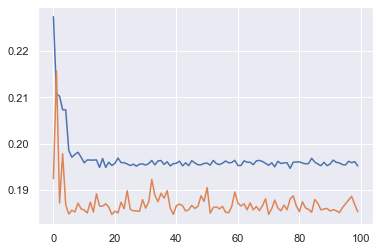

In [107]:
plt.plot(pplIlllosses)
plt.plot(pplIllvalidlosses)

In [109]:
ft_idx = 1
may = [date for date in test_date if '2019-08' in date]
resultpdEIll = PredictionMultipleDate(modelPPLIll,test_date,may[5], may[10],loaderEIlltest, seq_len, scalersY, myfloor, ft_idx)

<AxesSubplot:>

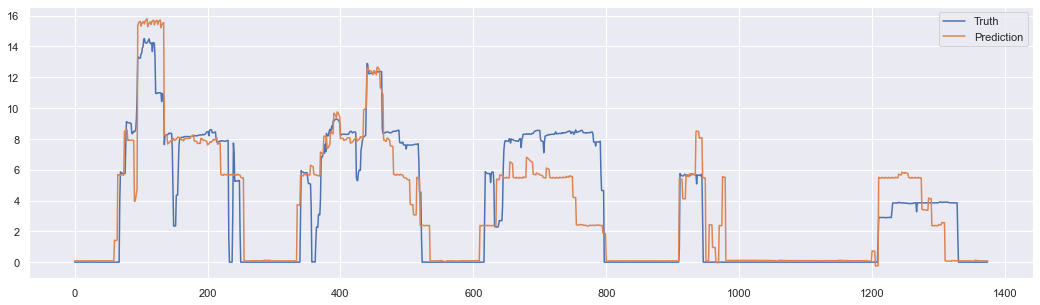

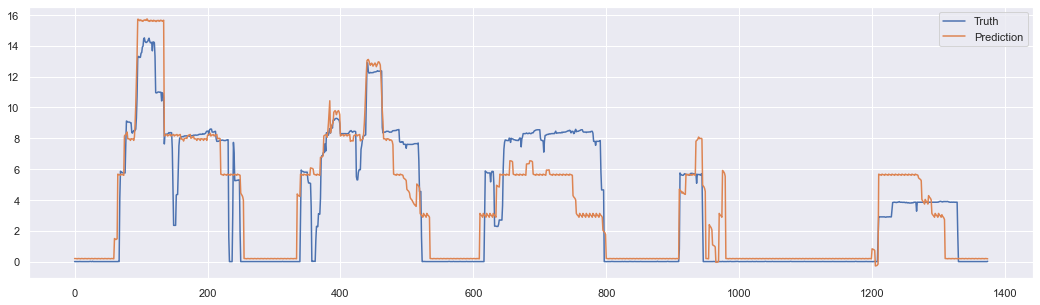

In [113]:
resultpdEIll[["Truth","Prediction"]].plot(figsize=(18,5))#,title="Model_"+str(indexroom))
resultpdLux[["Truth","Prediction"]].plot(figsize=(18,5))#,title="Model_"+str(indexroom))